<a href="https://colab.research.google.com/github/lapshinaaa/homework_DeepLearning/blob/main/hw4_texts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
<img src="https://raw.githubusercontent.com/dvgodoy/PyTorch101_ODSC_Europe2020/master/images/linear_dogs.jpg" width="800">

# Основы глубинного обучения: домашнее задание 4
</center>

**ФИО:** Лапшина Анастасия Андреевна

**Забавный факт о себе:**

## Общая информация

__Дата выдачи:__ 09.12.2023

__Дедлайн:__ 23:59MSK 18.12.2023

В случае этой домашки мягкий дедлан совпадает с жёстким.

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 5.2 балла (3 основных балла и ещё 2.2 бонусных).

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

In [1]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Описание данных

Данные можно [скачать с гугл-диска.](https://drive.google.com/drive/folders/11oCcLplWtp_qm-WuEbfCFP_Mz5K_z3ps?usp=sharing) Если вы делаете задание в колабе, то строчки ниже сами скачают вам данные.



In [3]:
import gdown

url = "https://drive.google.com/drive/folders/1CkvfZZJEIETBeGYfsmr3-L-od5VcV6YP?usp=sharing"
gdown.download_folder(url, quiet=True, use_cookies=False)

['/content/news_data/ria_news.tsv',
 '/content/news_data/vk_comments.tsv',
 '/content/news_data/vk_news.tsv']

В таблице `ria_news.tsv`  лежат данные о новостях, вышедших на сайте РИА-НОВОСТИ с 15 марта 2018 года по 31 декабря 2018 года.

- `href` - уникальный идентификатор новости (ссылка на неё)
- `date` - дата публикации новости
- `time` - время публикации новости
- `title` - заголовок новости
- `snippet` - краткое описание новости
- `text` - текст новости
- `category` - категория новости
- `keywords` - ключевые слова (подкатегории новости)
- `shows` - счётчик с числом просмотров новости на сайте (на момент парсинга)

In [4]:
df_ria = pd.read_csv('news_data/ria_news.tsv', sep='\t')
df_ria = df_ria[~df_ria.tags.isnull()]
print(df_ria.shape)
df_ria.head()

(201708, 9)


,href,date,time,title,snippet,text,category,tags,shows
0,/20181231/1548961410.html,2018-12-31,"31 декабря 2018, 23:52",Нетаньяху не собирается в отставку в случае пр...,Премьер-министр Израиля Биньямин Нетаньяху не ...,"МОСКВА, 31 дек - РИА Новости. Премьер-министр ...",В мире,"Биньямин Нетаньяху, Израиль, В мире",728.0
1,/20181231/1548961364.html,2018-12-31,"31 декабря 2018, 23:19",Макрон в новогоднем обращении затронул тему ре...,"Результат реформ не может быть мгновенным, зая...","ПАРИЖ, 31 дек – РИА Новости. Результат реформ ...",В мире,"Эммануэль Макрон, Франция, В мире",3086.0
2,/20181231/1548961337.html,2018-12-31,"31 декабря 2018, 23:12",Аарон Рэмзи проведет переговоры с пятью топ-кл...,"Полузащитник лондонского ""Арсенала"" Аарон Рэмз...","МОСКВА, 31 дек - РИА Новости. Полузащитник лон...",NaN,ФК Арсенал (Лондон),183.0
3,/20181231/1548961304.html,2018-12-31,"31 декабря 2018, 23:09",Гол Азмуна принес сборной Ирана победу над кат...,Футболисты сборной Ирана одержали победу над к...,"МОСКВА, 31 дек - РИА Новости. Футболисты сборн...",NaN,"Сердар Азмун, Сборная Ирана по футболу",78.0
4,/20181231/1548961265.html,2018-12-31,"31 декабря 2018, 23:07",Пятая ракетка мира дель Потро пропустит Открыт...,Аргентинский теннисист Хуан Мартин дель Потро ...,"МОСКВА, 31 дек - РИА Новости. Аргентинский тен...",NaN,Теннис,79.0


Многие новостные агенства поддерживают странички в социальных сетях. Они постят туда самые сочные сюжеты. В таблице `vk_news.tsv` лежат данные о новостях, которые РИА запостили ВКонтакте в период времени с  `2017-09-29 01:28:55` по `2019-02-01 23:13:17`.

- `id` - уникальный идентификатор поста
- `href` - ссылка на сайт (если она была указана в посте)
- `datetime` - дата и время публикации новости
- `title` - заголовок новости
- `text` - текст новости в социальной сети
- `likes` - число лайков под постом
- `comments` - число комментариев под постом

In [5]:
df_vk = pd.read_csv('news_data/vk_news.tsv', sep='\t')
df_vk['snippet'] = df_vk['text']
df_vk.drop('text', axis=1, inplace=True)
print(df_vk.shape)
df_vk.head()

(19928, 7)


,id,href,datetime,title,likes,comments,snippet
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",15,28,NaN
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",32,42,NaN
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",84,23,NaN
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,58,35,NaN
4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,Толкнувший Скабееву депутат Рады заявил о гроз...,45,145,NaN


В таблице `vk_comments.tsv` лежат комментарии к новостям.

- `id` - уникальный идентификатор комментария
- `post_id` - идентификатор новости, под которой был оставлен комментарий
- `datetime` - дата и время, когда был оставлен комментарий
- `text` - текст комментария
- `likes` - число лайков под комментарием

In [6]:
df_comments = pd.read_csv('news_data/vk_comments.tsv', sep='\t')
df_comments = df_comments[~df_comments.text.isnull()]
print(df_comments.shape)
df_comments.head()

(2612629, 5)


,id,post_id,datetime,text,likes
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0


# А что надо сделать то?

В тетрадке вам предстоит сделать следующие шаги:

1. Вы обучите нейросеть предсказывать категорию новости
2. Вы построите предсказания для тех новостей, где мы ничего не знаем о категории
3. Вы используете уже обученный для сентимент-анализа классификатор из библиотеки `hugging face` чтобы предсказать эмоциональную окраску каждого комментария
4. Вы проведёте аналитику по новостям, а именно построите топы из самых позитивных и негативных категорий и новостей

Для первого шага вам будет дан бэйзлайн. Если вы его прогоните, у вас получится базовая модель, которая даст некоторое качество решения задачи. Вам надо будет выяснить, насколько это качество оказалось хорошим, а затем внести в код некоторые улучшения.



## Часть 1: категоризация новостей (1.2 + 2 бонусных балла)

Каждой новости в соотвествие поставлены ключевые слова. Будем считать, что эти ключевые слова — тематики новости. Нужно научиться предсказывать тематики по тексту новости. Готовые тематики у нас есть только по новостям с сайта. Они за 2018 год. По новостям из ВКонтакте у нас тематик нет. Мы собираемся их предсказать.

Новости, опубликованные ВКонтакте, отличаются от новостей с сайта тем, что у них есть только титул и короткое описание. Странно будет обучать нейросеть на длинных текстах, а потом использовать её на коротких описаниях. Мы не будем так делать. Мы попробуем обучить базовый вариант нейронной сети только на заголовках новостей. Все, кто захочет получить бонусные баллы, смогут попробовать добавить в нейросеть сниппеты (так назыают короткие описания новостей).

## 1.1 Подготовка таргета

Поработаем с таргетом. Мы будем предсказывать переменную `tags`. Давайте выясним скоько уникальных тегов существует.

In [7]:
from collections import Counter

# удалим все лишние пробелы и сделаем lowercase
df_ria['tags'] = (
    df_ria.tags.
    apply(lambda w: ','.join([item.strip() for item in  w.lower().split(',')]))
)

tags = ','.join(list(df_ria.tags.values))
tags_cnt = Counter(tags.split(','))

print(len(tags_cnt))
tags_cnt.most_common()[-20:]

13344


[('блог анны завершинской об автоспорте - блоги', 1),
 ('министерство транспорта рб', 1),
 ('министерство здравоохранения грузии', 1),
 ('палех', 1),
 ('юрий посохов (хореограф)', 1),
 ('мария александрова', 1),
 ('том бенсон', 1),
 ('абдул каюм кочай', 1),
 ('нуман куртулмуш', 1),
 ('mipim', 1),
 ('владимир попов', 1),
 ('брюно женезио', 1),
 ('роберт фицо', 1),
 ('сергей пашинский', 1),
 ('валерия гонтарева', 1),
 ('нововоронеж', 1),
 ('императорское православное палестинское общество', 1),
 ('event_poslanie_prezidenta_rf_federalnomu_sobraniju', 1),
 ('фхтр', 1),
 ('игорь честин', 1)]

Всего в выборке есть порядка 13 000 тэгов. Многие встречаются всего по разу. Давайте оставим в выборке только те тэги, которые встречаются более 30 раз.

In [8]:
target_tags = {tag for tag,cnt in tags_cnt.most_common() if cnt > 30}
len(target_tags)

1583

Закодируем теги для OHE.

In [9]:
tag2idx = dict(zip(target_tags, range(len(target_tags))))
idx2tag = {jtem: item for item,jtem in tag2idx.items()}

Почистим таргет от лишних тэгов.

In [10]:
df_ria['target_tags'] = (
    df_ria.tags.
    apply(lambda w: [tag2idx.get(item) for item in  w.split(',') if item in target_tags])
)

df_ria = df_ria[df_ria.target_tags.apply(len) > 0]
df_ria.shape

(201437, 10)

In [11]:
df_ria.target_tags.values[:3]

array([list([1136, 550, 1492]), list([40, 594, 1492]), list([547])],
      dtype=object)

## 1.2 Подготовка текстов

Теперь займёмся предобработкой текстов. Приведём все слова к маленькому регистру и выбросим мусорные символы. В качестве токенов будем рассматривать отдельные слова.

Напомню, что мы пока что решили работать только с названиями статей. Поэтому вся предобработка применяется исключительно к ним. **Спойлер:** предобработку для сниппетов вы сделаете сами в первом же задании.

In [12]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [13]:
import re
from nltk.tokenize import word_tokenize

def normalise_text(text):
    text = text.lower()

    # сурово регулярками выкидываем мусорные символы
    text = re.sub('[^а-яa-z0-9 ]', '', text)
    return text.strip()

df_ria['title_clean'] = df_ria.title.apply(normalise_text)

word_cnt = Counter(word_tokenize(' '.join(df_ria.title_clean.values)))
len(word_cnt)

112178

In [14]:
word_cnt.most_common()[:10]

[('в', 127323),
 ('на', 44386),
 ('с', 26150),
 ('и', 21771),
 ('о', 19948),
 ('по', 17014),
 ('россии', 13494),
 ('не', 13483),
 ('сша', 9942),
 ('за', 9881)]

Давайте почистим словарь от стоп-слов и подготовим его к использованию внутри датасета. Мы будем с помощью словаря заменять слова на индексы. Добавим в словарь несколько специальных токенов для неизвестных слов и паддингов.

In [15]:
from nltk.corpus import stopwords

stops_ru = set(stopwords.words('russian'))
len(stops_ru)

151

In [16]:
vocabulary = {
    "#PAD#": 0, "#UNK#": 1
}

k = 2
for word, _ in word_cnt.most_common():
    if word not in stops_ru:
        vocabulary[word] = k
        k += 1

In [17]:
len(vocabulary)

112030

Завернём код для создания словаря в функцию.

In [18]:
def create_vocab(text, stops_ru=stops_ru):

    word_cnt = Counter(word_tokenize(text))
    vocabulary = {
        "#PAD#": 0, "#UNKN#": 1
    }

    k = 2
    for word, _ in word_cnt.most_common():
        if word not in stops_ru:
            vocabulary[word] = k
            k += 1
    return vocabulary

__[0.2 балла] Задание 1:__

- Cделайте аналогичную предобработку титулов из таблички `df_vk`. Запишите получившийся результат в столбец `title_clean` по аналогии с таблицей `df_ria`.
- Сделайте для обеих таблиц предобработку колонок со сниппетами `snippet` и запишите получившийся результат в столбец `snippet_clean`. Все пропуски заполните токеном `"#UNKN"`.

In [19]:
df_vk['title_clean'] = df_vk.title.apply(normalise_text)
df_vk['title_clean']

0        в днр заявили о задержании диверсантов причаст...
1        житель урала заминировал тц изза снятия  сотов...
2              в черном море нашли потерянный флот гитлера
3        в сша освободили задержанную российскую актрис...
4        толкнувший скабееву депутат рады заявил о гроз...
                               ...                        
19923    политологи назвали губернаторов которым грозит...
19924    захарова рассказала какую книгу подписывал лав...
19925    современные люди появились более 300 тысяч лет...
19926                       в сша ребенок устроил стрельбу
19927    в россии впервые сократили число призывников н...
Name: title_clean, Length: 19928, dtype: object

In [20]:
# preprocessing both tables' "snippet" column
df_ria['snippet_clean'] = df_ria.snippet.apply(lambda x: normalise_text(x) if pd.notnull(x) else '#UNKN')
df_vk['snippet_clean'] = df_vk.snippet.apply(lambda x: normalise_text(x) if pd.notnull(x) else '#UNKN')

df_vk['snippet_clean']

0        #UNKN
1        #UNKN
2        #UNKN
3        #UNKN
4        #UNKN
         ...  
19923    #UNKN
19924    #UNKN
19925    #UNKN
19926    #UNKN
19927    #UNKN
Name: snippet_clean, Length: 19928, dtype: object

In [ ]:
# ria_snippet_clean_dtype = df_ria['snippet_clean'].dtype
# print("Data type of 'snippet_clean' column in df_ria:", ria_snippet_clean_dtype)

# vk_snippet_clean_dtype = df_vk['snippet_clean'].dtype
# print("Data type of 'snippet_clean' column in df_vk:", vk_snippet_clean_dtype)

In [ ]:
df_ria.head(3)

,href,date,time,title,snippet,text,category,tags,shows,target_tags,title_clean,snippet_clean
0,/20181231/1548961410.html,2018-12-31,"31 декабря 2018, 23:52",Нетаньяху не собирается в отставку в случае пр...,Премьер-министр Израиля Биньямин Нетаньяху не ...,"МОСКВА, 31 дек - РИА Новости. Премьер-министр ...",В мире,"биньямин нетаньяху,израиль,в мире",728.0,"[1480, 1215, 758]",нетаньяху не собирается в отставку в случае пр...,премьерминистр израиля биньямин нетаньяху не н...
1,/20181231/1548961364.html,2018-12-31,"31 декабря 2018, 23:19",Макрон в новогоднем обращении затронул тему ре...,"Результат реформ не может быть мгновенным, зая...","ПАРИЖ, 31 дек – РИА Новости. Результат реформ ...",В мире,"эммануэль макрон,франция,в мире",3086.0,"[36, 1526, 758]",макрон в новогоднем обращении затронул тему ре...,результат реформ не может быть мгновенным заяв...
4,/20181231/1548961265.html,2018-12-31,"31 декабря 2018, 23:07",Пятая ракетка мира дель Потро пропустит Открыт...,Аргентинский теннисист Хуан Мартин дель Потро ...,"МОСКВА, 31 дек - РИА Новости. Аргентинский тен...",NaN,теннис,79.0,[426],пятая ракетка мира дель потро пропустит открыт...,аргентинский теннисист хуан мартин дель потро ...


## 1.3 Поставка данных

Пересечение сайта и ВК по опубликованным новостям довольно маленькое. Мы обучаем модель на данных с сайта. Предсказания мы будем строить на данных из ВК. У этих данных разная природа. В ВК описание статей и заголовки короче. Модель может хорошо показать себя на данных с новостного сайта, но сильно просесть в качестве на данных из ВК.

Давайте сохраним пересечение в отдельную табличку, чтобы на нём можно было понять, насколько сильно деградирует модель.

In [21]:
ria_hrefs = set(df_ria.href.values)
vk_hrefs = set(df_vk.href.values)
test_hrefs = (vk_hrefs & ria_hrefs)

print('Размер отложенной выборки:', len(test_hrefs))

df = df_ria[~df_ria.href.isin(test_hrefs)]

Размер отложенной выборки: 1128


По странному совпадению (я правда не знаю почему) пересечение лежит в декабре. Мы будем его использовать как тестовую выборку.

In [22]:
df_ria[df_ria.href.isin(test_hrefs)].date.min(), df_ria[df_ria.href.isin(test_hrefs)].date.max()

('2018-12-06', '2018-12-31')

Предположим, что мы делим выборку на обучающую и тестовую случайно. За один и тот же промежуток времени может выйти довольно большое число новостей с одинаковым заголовком. Давайте представим себе, что в тесте и трэйне есть много статей про одно и то же событие. Модель научилась на обучающей выборке хорошо его тегировать. Остальные события модель тегирует намного хуже. Метрики на тестовой выборке высокие. В следующем месяце СМИ перестают освещать это событие, в потоке новостей совершенно другие новости. Качество модели резко проседает.

Чтобы не напороться на завышенные метрики, обычно выборку дробят на обучающую и тестовую по времени. Тогда статьи из теста будут имитировать поток новых новостей, освещающих новые события.

In [23]:
df.date.min(), df.date.max()

('2018-03-15', '2018-12-31')

__[0.2 балла] Задание 2:__ Разбейте выборку на обучающую, валидационную и тестовую. В тест возьмите весь декабрь. В валидацию октябрь и ноябрь.

**How to convert the column type from string to datetime:** https://www.geeksforgeeks.org/convert-the-column-type-from-string-to-datetime-format-in-pandas-dataframe/

https://stackoverflow.com/questions/17134716/convert-dataframe-column-type-from-string-to-datetime

In [24]:
# converting from string to datetime to specify the range later on
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# specifying the time periods
train_end_date = '2018-09-30'
val_end_date = '2018-11-30'
test_end_date = '2018-12-31'

df_test = df[(df['date'] > val_end_date) & (df['date'] <= test_end_date)]
df_val = df[(df['date'] > train_end_date) & (df['date'] <= val_end_date)]
df_train = df[df['date'] <= train_end_date]

In [ ]:
df_train.head()

,href,date,time,title,snippet,text,category,tags,shows,target_tags,title_clean,snippet_clean
64835,/20180930/1529669120.html,2018-09-30,"30 сентября 2018, 23:59",Обвинившую Кавано в домогательствах американку...,<p><strong></strong></p>\n<p><strong>ВАШИНГТО...,"\nВАШИНГТОН, 30 сен — РИА Новости. Обвинившая ...",В мире,"сша,в мире",3372.0,"[975, 758]",обвинившую кавано в домогательствах американку...,pstrongstrongppstrongвашингтон 30 сен риа ново...
64836,/20180930/1529669084.html,2018-09-30,"30 сентября 2018, 23:57",Полиция сообщила об обстановке в башкирском се...,"<p><strong>УФА, 30 сен – РИА Новости.</strong...","УФА, 30 сен – РИА Новости. В Баймакском районе...",Происшествия,"республика башкортостан,происшествия",6345.0,"[579, 949]",полиция сообщила об обстановке в башкирском се...,pstrongуфа 30 сен риа новостиstrong в баймакс...
64837,/20180930/1142994754.html,2018-09-30,"30 сентября 2018, 23:55","Червиченко: ""Зенит"" в матче с ""Анжи"" подвели д...","""Зенит"" в воскресенье на выезде уступил ""Анжи""...","\nС.-ПЕТЕРБУРГ, 30 сен - РИА Новости, Тарас Ба...",Спорт,"андрей червиченко,спорт,футбол",2.0,"[1067, 97]",червиченко зенит в матче с анжи подвели две ду...,зенит в воскресенье на выезде уступил анжи в м...
64838,/20180930/1529669017.html,2018-09-30,"30 сентября 2018, 23:51",Франция готова помочь Индонезии после землетря...,"<p><strong></strong></p>\n<p><strong>ПАРИЖ, 3...","\nПАРИЖ, 30 сен — РИА Новости, Виктория Иванов...",В мире,"землетрясение в индонезии,индонезия,в мире",442.0,"[402, 431, 758]",франция готова помочь индонезии после землетря...,pstrongstrongppstrongпариж 30 сен риа новости ...
64839,/20180930/1529668973.html,2018-09-30,"30 сентября 2018, 23:49",В Иране троих человек приговорили к смертной к...,"<p><strong></strong></p>\n<p><strong>МОСКВА, ...","\nМОСКВА, 30 сен — РИА Новости. Трех человек п...",В мире,"иран,в мире",754.0,"[843, 758]",в иране троих человек приговорили к смертной к...,pstrongstrongppstrongмосква 30 сен риа новости...


In [ ]:
df_test.head()

,href,date,time,title,snippet,text,category,tags,shows,target_tags,title_clean,snippet_clean
0,/20181231/1548961410.html,2018-12-31,"31 декабря 2018, 23:52",Нетаньяху не собирается в отставку в случае пр...,Премьер-министр Израиля Биньямин Нетаньяху не ...,"МОСКВА, 31 дек - РИА Новости. Премьер-министр ...",В мире,"биньямин нетаньяху,израиль,в мире",728.0,"[1480, 1215, 758]",нетаньяху не собирается в отставку в случае пр...,премьерминистр израиля биньямин нетаньяху не н...
1,/20181231/1548961364.html,2018-12-31,"31 декабря 2018, 23:19",Макрон в новогоднем обращении затронул тему ре...,"Результат реформ не может быть мгновенным, зая...","ПАРИЖ, 31 дек – РИА Новости. Результат реформ ...",В мире,"эммануэль макрон,франция,в мире",3086.0,"[36, 1526, 758]",макрон в новогоднем обращении затронул тему ре...,результат реформ не может быть мгновенным заяв...
4,/20181231/1548961265.html,2018-12-31,"31 декабря 2018, 23:07",Пятая ракетка мира дель Потро пропустит Открыт...,Аргентинский теннисист Хуан Мартин дель Потро ...,"МОСКВА, 31 дек - РИА Новости. Аргентинский тен...",NaN,теннис,79.0,[426],пятая ракетка мира дель потро пропустит открыт...,аргентинский теннисист хуан мартин дель потро ...
5,/20181231/1548961218.html,2018-12-31,"31 декабря 2018, 23:06",СМИ: Кевину Спейси не разрешили отсутствовать ...,Суд в американском штате Массачусетс отверг хо...,"МОСКВА, 31 дек - РИА Новости. Суд в американск...",В мире,"кевин спейси,сша,в мире",2058.0,"[975, 758]",сми кевину спейси не разрешили отсутствовать н...,суд в американском штате массачусетс отверг хо...
6,/20181231/1548961194.html,2018-12-31,"31 декабря 2018, 23:06","""Зимняя классика"" НХЛ в 2020 году пройдет в Да...","""Зимняя классика"" - матч регулярного чемпионат...","МОСКВА, 31 дек - РИА Новости. ""Зимняя классика...",NaN,"нхл,хоккей",89.0,"[708, 156]",зимняя классика нхл в 2020 году пройдет в далл...,зимняя классика матч регулярного чемпионата н...


In [25]:
# checking if the date ranges are correct
print('Training set:', df_train['date'].min(), df_train['date'].max())
print('Validation set:', df_val['date'].min(), df_val['date'].max())
print('Test set:', df_test['date'].min(), df_test['date'].max())

Training set: 2018-03-15 00:00:00 2018-09-30 00:00:00
Validation set: 2018-10-01 00:00:00 2018-11-30 00:00:00
Test set: 2018-12-01 00:00:00 2018-12-31 00:00:00


Сформируем отложенную выборку (пересечение ВКонтакте и РИА).

In [26]:
df_oob = df_vk[df_vk.href.isin(test_hrefs)][['href', 'title_clean']]

df_ria_oob = df_ria[df_ria.href.isin(test_hrefs)][['href', 'target_tags']]
df_oob = df_oob.set_index('href').join(df_ria_oob.set_index('href')).reset_index()
df_oob.head()

,href,title_clean,target_tags
0,/20181206/1547493936.html,эксперты определили самые бюджетные экзотическ...,"[1234, 411]"
1,/20181206/1547516457.html,рада приняла закон расширяющий контролируемую ...,"[1455, 1492]"
2,/20181206/1547520788.html,россия оказалась родиной древнейших титанозавр...,"[1464, 887]"
3,/20181206/1547521406.html,школа в красноярске превратилась в хогвартс из...,[1324]
4,/20181206/1547522342.html,рада решила не продлевать договор о дружбе и с...,"[1173, 1492]"


Напишем датасет для поставки данных в нейросеть.


In [27]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class NewsDataset(Dataset):

    def __init__(self, target, title, vocab, vocab_size, max_title_len, max_classes, snippet=None, max_snippet_len=None):

       self.vocab = {word: idx  for word,idx in vocab.items() if idx < vocab_size}
       self.max_classes = max_classes
       self.y=self.target_ohe(target)
       self.X_title = self.create_text(title, max_title_len)

       # checking if snippet attribute is present
       if snippet is not None:
        self.X_snippet = self.create_text(snippet, max_snippet_len)

    def target_ohe(self, target):
        y = torch.zeros((len(target), self.max_classes))
        for i, t in enumerate(target):
            y[[i]*len(t), t] = 1.0
        return y

    def create_text(self, texts, max_len):
        result = [ ]
        for sent in texts:
            # {#PAD: 0, #UNKN: 1}
            sent_tokenize = [self.vocab.get(item, 1) for item in word_tokenize(sent)]

            # приводим все тексты к max_len
            if len(sent_tokenize) >= max_len:
                sent_tokenize = sent_tokenize[:max_len]
            else:
                sent_tokenize += [0] * (max_len - len(sent_tokenize))
            result.append(sent_tokenize)
        return torch.tensor(result, dtype=torch.int)

    def __len__(self):
        return len(self.X_title)

    def __getitem__(self, idx):
      # if 'snippet' is present, returning 3 items else: 2
      if hasattr(self, 'X_snippet'):
          return (self.X_title[idx, :], self.X_snippet[idx, :], self.y[idx])
      else:
          return (self.X_title[idx, :], self.y[idx])

__[0.2 балла] Задание 3:__ Сейчас датасет умеет работать только с полем `title_clean`. Давайте сделаем этот датасет более многофукнциональным и добавим в него возможность добавить в обработку данных сниппет.

1. Внутри датасета `snippet` надо обработать точно также как и `title`.
2. Если `snippet=None`, датасет должен вернуть два объекта: `X_title, y`. В обратном случае датасет должен вернуть три объекта.

**Важно:** Весь код ниже работает сейчас без сниппета. Он не должен развалиться от того, что сниппет в нём нигде не указан.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

# Внесите в код датасета выше свои правки

Объявим датасеты, оставим в словаре 30 000 самых частотных слов. Будем смотреть на титулы максимальной длины 20.

In [28]:
CLASSES_NUM = len(idx2tag)
VOCAB_SIZE = 10000
MAX_TITLE_LEN = 20

# словарь создаем по всей выборке
vocabulary = create_vocab(' '.join(df_ria.title_clean.values))

In [29]:
# объявляем датасеты
train_dataset = NewsDataset(df_train.target_tags.values, df_train.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )
val_dataset = NewsDataset(df_val.target_tags.values, df_val.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )
test_dataset = NewsDataset(df_test.target_tags.values, df_test.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )

In [30]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64, num_workers=4)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=4096, num_workers=4)

## 1.4 Архитектуры

Соберём базовую архитектуру для обучения.

In [42]:
from torch import nn
import torch.nn.functional as F

In [55]:
class SimpleClassifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, title):
        embedded = self.embedding(title)
        embedded = embedded.mean(dim=1)
        return self.fc(embedded)

In [31]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 11.2 MB/s eta 0:00:00


Соберём в `pytorch_lightning` модуль для обучения нейронки.

In [33]:
!pip3 install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 15.5 MB/s eta 0:00:00


In [34]:
import wandb
from pytorch_lightning.loggers import WandbLogger
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [36]:
import pytorch_lightning as pl

class TrainLightningModule(pl.LightningModule):
    def __init__(self, model, learning_rate, criterion):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.learning_rate = learning_rate

    def forward(self, title):
        result = self.model(title)
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        if len(train_batch) == 3:
            title, snippet, target = train_batch
        else:
            title, target = train_batch

        logits = self.model(title, snippet) if len(train_batch) == 3 else self.model(title)
        loss = self.criterion(logits, target)
        self.log(
            "train_loss", loss, prog_bar=True
        )

        # logging additional information with Wandb
        wandb.log({"train_loss": loss})

        return loss

    def validation_step(self, val_batch, batch_idx):
        if len(val_batch) == 3:
            title, snippet, target = val_batch
        else:
            title, target = val_batch

        logits = self.model(title, snippet) if len(val_batch) == 3 else self.model(title)
        loss = self.criterion(logits, target)
        loss = self.criterion(logits, target)
        self.log(
            "val_loss", loss, prog_bar=True
        )

        # logging additional information with Wandb
        wandb.log({"validation_loss": loss})

        return loss

Обучим модель.

In [56]:
EMBEDDING_DIM = 300
EPOCHS = 5
LR = 1e-3

wandb_logger = WandbLogger(name='Simple Model (no snippets)', log_model='all')
model_baseline = SimpleClassifier(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM)
criterion = torch.nn.CrossEntropyLoss()

train_module =TrainLightningModule(model_baseline, LR, criterion)

trainer = pl.Trainer(logger=wandb_logger, accelerator="gpu", max_epochs=EPOCHS)
trainer.fit(train_module, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | SimpleClassifier | 3.5 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
13.906    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


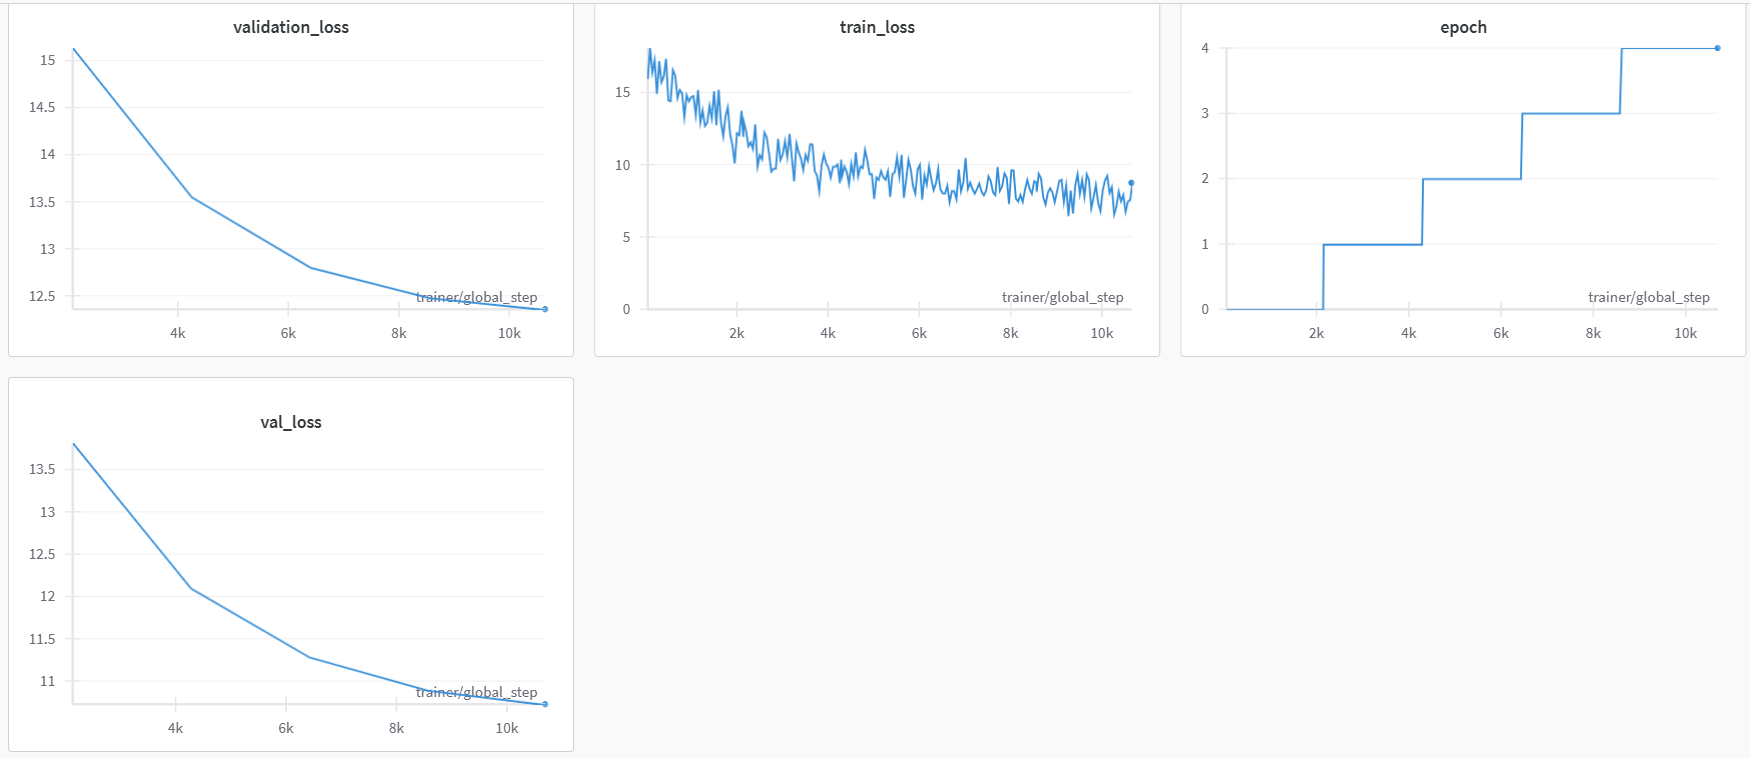

__[0.2 балла] Задание 4:__  Модель выше работает только с титулом.

- Залоггируйте её обучение на [WandB](https://wandb.ai/).
- Соберите архитектуру, которая будет принимать на вход не только титул, но ещё и сниппет. В этой архитектуре должно происходить следующее:

1. Общий слой `nn.Embedding` применяется к сниппету и титулу параллельно.
2. Происходит усреднее по текстам.
3. Вектора конкатятся в один длины 600
4. Линейный слой делает классификацию

Обучите эту модель. Сравните траектории обучения на WandB. Прикрепите ссылку на дашборд либо скришот к тетрадке.

Даталоадеры придётся объявить заново с учётом сниппетов. Правда ли, что она бьёт на валидационной выборке модель, обученную только на титулах статей?

In [ ]:
# new dataloaders
train_dataset = NewsDataset(df_train.target_tags.values, df_train.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM, df_train.snippet_clean.values, max_snippet_len=MAX_TITLE_LEN)
val_dataset = NewsDataset(df_val.target_tags.values, df_val.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM, df_val.snippet_clean.values, max_snippet_len=MAX_TITLE_LEN)
test_dataset = NewsDataset(df_test.target_tags.values, df_test.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM, df_test.snippet_clean.values, max_snippet_len=MAX_TITLE_LEN)

In [ ]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64, num_workers=4)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=4096, num_workers=4)

In [ ]:
# creating a new model architecture to process snippets, too
class ComplexClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        self.embedding_title = nn.Embedding(vocab_size, embedding_dim)
        self.embedding_snippet = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim * 2, output_dim)

    def forward(self, title, snippet):
      # simultaneously processing titles and snippets
    #    print(type(title))
        embedded_title = self.embedding_title(title)
        embedded_snippet = self.embedding_snippet(snippet)

        embedded_title = embedded_title.mean(dim=1)
        embedded_snippet = embedded_snippet.mean(dim=1)

      # concatenate results
        concatenated = torch.cat((embedded_title, embedded_snippet), dim=1)
        return self.fc(concatenated)

In [ ]:
wandb_logger_new = WandbLogger(name='Complex Updated Model (snippets processing)', log_model='all')
model_complex = ComplexClassifier(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM)
criterion = torch.nn.CrossEntropyLoss()

train_module =TrainLightningModule(model_complex, LR, criterion)

trainer_updated = pl.Trainer(logger=wandb_logger_new, accelerator="gpu", max_epochs=EPOCHS)
trainer_updated.fit(train_module, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params
------------------------------------------------
0 | model     | ComplexClassifier | 7.0 M 
1 | criterion | CrossEntropyLoss  | 0     
------------------------------------------------
7.0 M     Trainable params
0         Non-trainable params
7.0 M     Total params
27.806    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


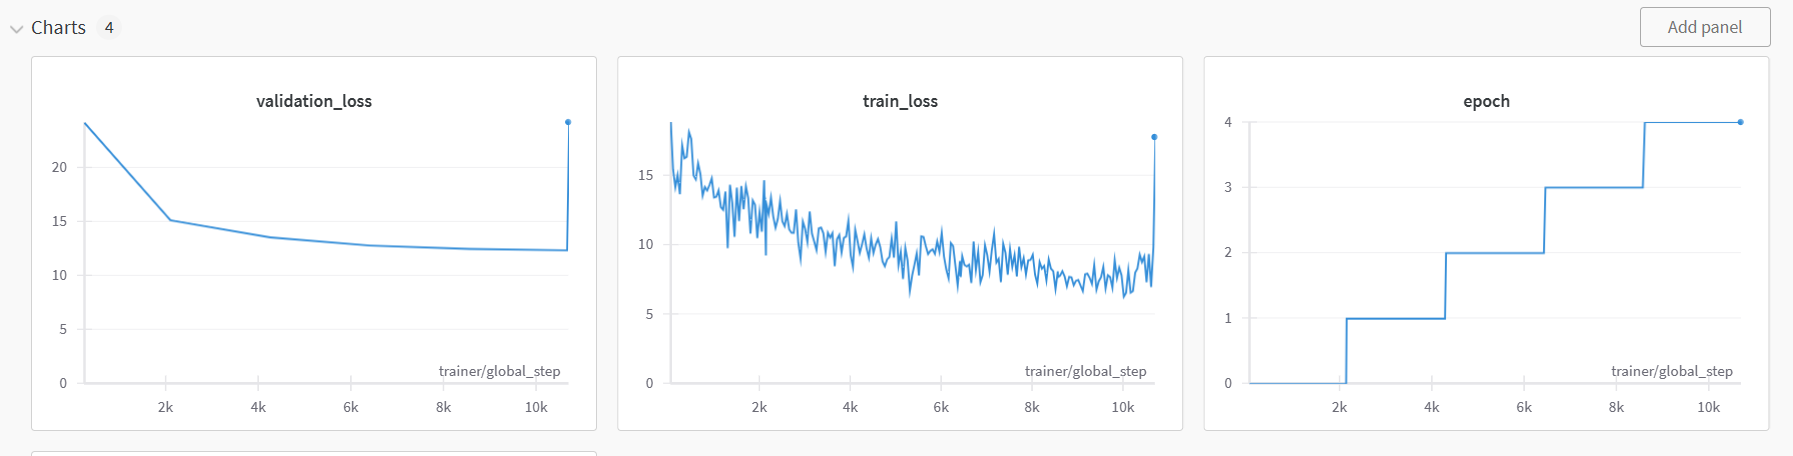

**RESULTS:** the validation loss results show that the first model outperformed the second, more complex one (not sure if that's the expected outcome of this experiment, but that's what we've got).

## 1.5 Инференс и оценка качества моделей

Для каждой новости нам надо предсказывать несколько тэгов. То есть в нашем случае настоящее значение таргета это множество из тэгов $y_i = [tag1, tag2, tag3]$. Прогноз модели также множество из тэгов $\hat y_i = [tag1, tag4]$.

Будем считать метрики качества следующим образом (под $|A|$ имеется в виду мощность множества, то есть число элементов в нём):

$$
Precision = \frac{1}{n} \sum_{i = 1}^n \frac{|y_i \cap \hat{y}_i|}{|\hat{y}_i|}
$$

$$
Recall = \frac{1}{n} \sum_{i = 1}^n \frac{|y_i \cap \hat{y}_i|}{|y_i|}
$$

Также можно считать аналог Accuracy, но это не самая удачная идея, так как у нас в выборке огромное число нулей и эта метрика при любом разумном пороге для принятия решения будет очень высокой.

$$
Exact Match = \frac{1}{n} \cdot \frac{1}{k} \sum_{i = 1}^n \sum_{k=1}^K [y_{ij} = \hat{y}_{ij}]
$$

In [37]:
def precision(target, y_pred):
    num = ((y_pred == 1) & (target == 1)).sum(dim=1)
    denum = (y_pred == 1).sum(dim=1)
    return (num/(denum + 1e-5)).mean().item()

def recall(target, y_pred):
    num = ((y_pred == 1) & (target == 1)).sum(dim=1)
    denum = (target == 1).sum(dim=1)
    return (num/(denum + 1e-5)).mean().item()

def exact_match(target, y_pred):
    return (1.*(y_pred == target)).mean().item()

In [72]:
#test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=test_dataset.__len__())

Построим прогноз на тестовой выборке.

In [ ]:
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=test_dataset.__len__())

for title, target in test_dataloader:
#    first_batch = next(iter(test_dataloader))
 #   print(len(first_batch))
    logit = model_baseline(title)
    pred_prob = F.softmax(logit, dim=1)

assert pred_prob.shape[0] == test_dataset.__len__()

Теперь выбирая различное значение порога, мы можем получать разные предсказания. Если взять очень большое значение порога, то метрики сильно просядут, так как во многих документах никакого прогноза не будет построено вообще.

In [ ]:
TRESHOLD = 0.01
y_pred = 1*(pred_prob > TRESHOLD)

print('Exact Match:', exact_match(target, y_pred))
print('Precision:', precision(target, y_pred))
print('Recall:', recall(target, y_pred))

Exact Match: 0.9955400228500366
Precision: 0.2911209464073181
Recall: 0.7624239325523376


In [ ]:
TRESHOLD = 0.05
y_pred = 1*(pred_prob > TRESHOLD)
print('Exact Match:', exact_match(target, y_pred))
print('Precision:', precision(target, y_pred))
print('Recall:', recall(target, y_pred))

Exact Match: 0.9983190298080444
Precision: 0.5182140469551086
Recall: 0.6190178990364075


In [ ]:
TRESHOLD = 0.9
y_pred = 1*(pred_prob > TRESHOLD)

print('Exact Match:', exact_match(target, y_pred))
print('Precision:', precision(target, y_pred))
print('Recall:', recall(target, y_pred))

Exact Match: 0.9983181357383728
Precision: 0.005798911210149527
Recall: 0.005133938044309616


Дальше мы будем строить довольно много прогнозов. Давайте напишем код для их строительства в виде функции. Обратите внимание, что на модели со снипетом она упадёт. Когда вы доберётесь до строительства прогнозов, функцию придётся немного модернизировать.

In [39]:
def get_predict(model, dataset):
    dataloader = DataLoader(dataset, shuffle=False, batch_size=dataset.__len__())
    first_batch = next(iter(dataloader))

    # if we're having a dataloader without snippets
    if len(first_batch) == 2:
        pred_prob, target = None, None
        for title, target in dataloader:
            logit = model_baseline(title)
            pred_prob = F.softmax(logit, dim=1)

            assert pred_prob.shape[0] == dataset.__len__()

    # handle the case with snippets in a dataloader
    else:
        pred_prob, target = None, None
        for title, target, snippet in dataloader:
          #  print(type(snippet))
          #  print(snippet)
            snippet = snippet.to(torch.long)
            logit = model_complex(title, snippet)
            pred_prob = F.softmax(logit, dim=1)

            assert pred_prob.shape[0] == dataset.__len__()
    return pred_prob, target

__[0.2 балла] Задание 5:__ Какая метрика для нас в этой задаче важнее? Точность или полнота? Почему?

__ваш ответ:__ precision, поскольку кажется, что ошибаться в своих предиктах стоит в данной задаче дороже, нежели находить корректные метки для всех задач из пула.

- Напишите функцию, которая будет подбирать оптимальное значение порога, оптимизирующее выбранную вами метрику.
- Подберите значение порога на валидационной выборке.
- Сравните модель со сниппетами и без сниппетов, используя выбранную вами метрику при оптимальном значении порога на тестовой выборке.
- Какая из них оказалась лучше?

In [40]:
# function for finding the best value of threshold for precision metric
def find_optimal_threshold_precision(model, dataset):
    pred_prob, target = get_predict(model, dataset)

    best_precision = 0.0
    optimal_threshold = 0.0

    for threshold in [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.5]:
        y_pred = (pred_prob > threshold).float()

        current_precision = precision(target, y_pred)

        if current_precision > best_precision:
            best_precision = current_precision
            optimal_threshold = threshold

    return optimal_threshold, best_precision

**Finding the best threshold for the baseline model on the validation portion of the dataset:**

In [ ]:
optimal_threshold, best_precision = find_optimal_threshold_precision(model_baseline, val_dataset)

print(f"Optimal Threshold: {optimal_threshold}")
print(f"Best Precision: {best_precision}")

Optimal Threshold: 0.1
Best Precision: 0.7186492085456848


**Comparing models' performances on test dataset with 0.1 threshold**

In [71]:
threshold_value = optimal_threshold

In [ ]:
# making predictions using baseline model
y_prob_baseline, target = get_predict(model_baseline, test_dataset)
y_pred_baseline = 1*(y_prob_baseline > threshold_value)

print('Exact Match for Baseline Model:', exact_match(target, y_pred_baseline))
print('Precision for Baseline Model:', precision(target, y_pred_baseline))
print('Recall for Baseline Model:', recall(target, y_pred_baseline))

Exact Match for Baseline Model: 0.98915862027434
Precision for Baseline Model: 0.7186492085456848
Recall for Baseline Model: 0.657369854511474


In [ ]:
# making predictions using a more complex model
y_prob_complex, target = get_predict(model_complex, test_dataset)
y_pred_complex = 1*(y_prob_complex > threshold_value)

print('Exact Match for Snippet Model:', exact_match(target, y_pred_complex))
print('Precision for Snippet Model:', precision(target, y_pred_complex))
print('Recall for Snippet Model:', recall(target, y_pred_complex))

Exact Match for Snippet Model: 0.9654778922854217
Precision for Snippet Model: 0.522478954785242
Recall for Snippet Model: 0.497236547858456


**Results:** for the optimal value of threshold, the first model (with no snippets - baseline model) performed significantly better than the second one, and will, therefore, be used later on in the remainder of the tasks.

__[0.2 балла] Задание 6:__  Постройте прогнозы для отложенной выборки, которая представляет из себя пересечение сайта РИА-новостей и ВКонтакте. Проседает ли на ней качество модели? Насколько сильно?

In [ ]:
df_oob.head()

,href,title_clean,target_tags
0,/20181206/1547493936.html,эксперты определили самые бюджетные экзотическ...,"[81, 1494]"
1,/20181206/1547516457.html,рада приняла закон расширяющий контролируемую ...,"[847, 758]"
2,/20181206/1547520788.html,россия оказалась родиной древнейших титанозавр...,"[206, 170]"
3,/20181206/1547521406.html,школа в красноярске превратилась в хогвартс из...,[1383]
4,/20181206/1547522342.html,рада решила не продлевать договор о дружбе и с...,"[123, 758]"


In [ ]:
# creating a new dataset based on РИА-ВК intersection
oob_dataset = NewsDataset(df_oob.target_tags.values, df_oob.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM)

baseline_pred_prob, baseline_target = get_predict(model_baseline, oob_dataset)
baseline_y_pred = 1 * (baseline_pred_prob > optimal_threshold)

# calculating metrics
precision_baseline = precision(baseline_target, baseline_y_pred)
recall_baseline = recall(baseline_target, baseline_y_pred)
exact_match_baseline = exact_match(baseline_target, baseline_y_pred)

print('Baseline Model Metrics on Intersection of RIA and VK:')
print(f'Precision: {precision_baseline}')
print(f'Recall: {recall_baseline}')
print(f'Exact Match: {exact_match_baseline}')

Baseline Model Metrics on Intersection of RIA and VK:
Precision: 0.5374050736427307
Recall: 0.4634217917919159
Exact Match: 0.9985302686691284


**Results:** the quality of the baseline model's performance is worse on this portion of data. The exact match is still pretty good, however the more important metrics, such as precision and recall, are significantly lower compared to previous results.

## 1.6 Бонусное задание

Давайте модернизируем наши архитектуры настолько, насколько это возможно.

__[0.5 балла]__ Попробуйте собрать более большую архитектуру. Например, сразу после слоя эмбеддингов вы можете попробовать добавить свёрточные слои (`Conv1D` свёртки). Поиграйте с оптимизатором и тп.

Опишите результаты своих экспериментов ниже. Расскажите, что конкретно вы делали и удалось ли вам улучшить качество модели. Все траектории обучения залоггируйте на WandB.   

__Ваш лог экспериментов:__

-
-
-

In [52]:
class ConvClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim):
        super(ConvClassifier, self).__init__()
        self.embedding_title = nn.Embedding(vocab_size, embedding_dim)

        # adding convolutional layers
        self.conv1 = nn.Conv1d(embedding_dim, 64, kernel_size=5)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3)

        self.fc1 = nn.Linear(128, output_dim)

    def forward(self, title):
        embedded_title = self.embedding_title(title)

        # relu activation for each of the conv1d layers
        conv1_output = F.relu(self.conv1(embedded_title.permute(0, 2, 1)))
        conv2_output = F.relu(self.conv2(conv1_output))

        pooled_output = F.adaptive_avg_pool1d(conv2_output, 1).squeeze(2)

        return self.fc1(pooled_output)

In [53]:
EMBEDDING_DIM = 300
EPOCHS = 7
LR = 1e-3

In [54]:
wandb_logger_new = WandbLogger(name='Model with Conv1D layers (no snippets)', log_model='all')
model_conv = ConvClassifier(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM)
criterion = torch.nn.CrossEntropyLoss()

train_module =TrainLightningModule(model_conv, LR, criterion)

trainer_updated = pl.Trainer(logger=wandb_logger_new, accelerator="gpu", max_epochs=EPOCHS)
trainer_updated.fit(train_module, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ConvClassifier   | 3.3 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.300    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=7` reached.


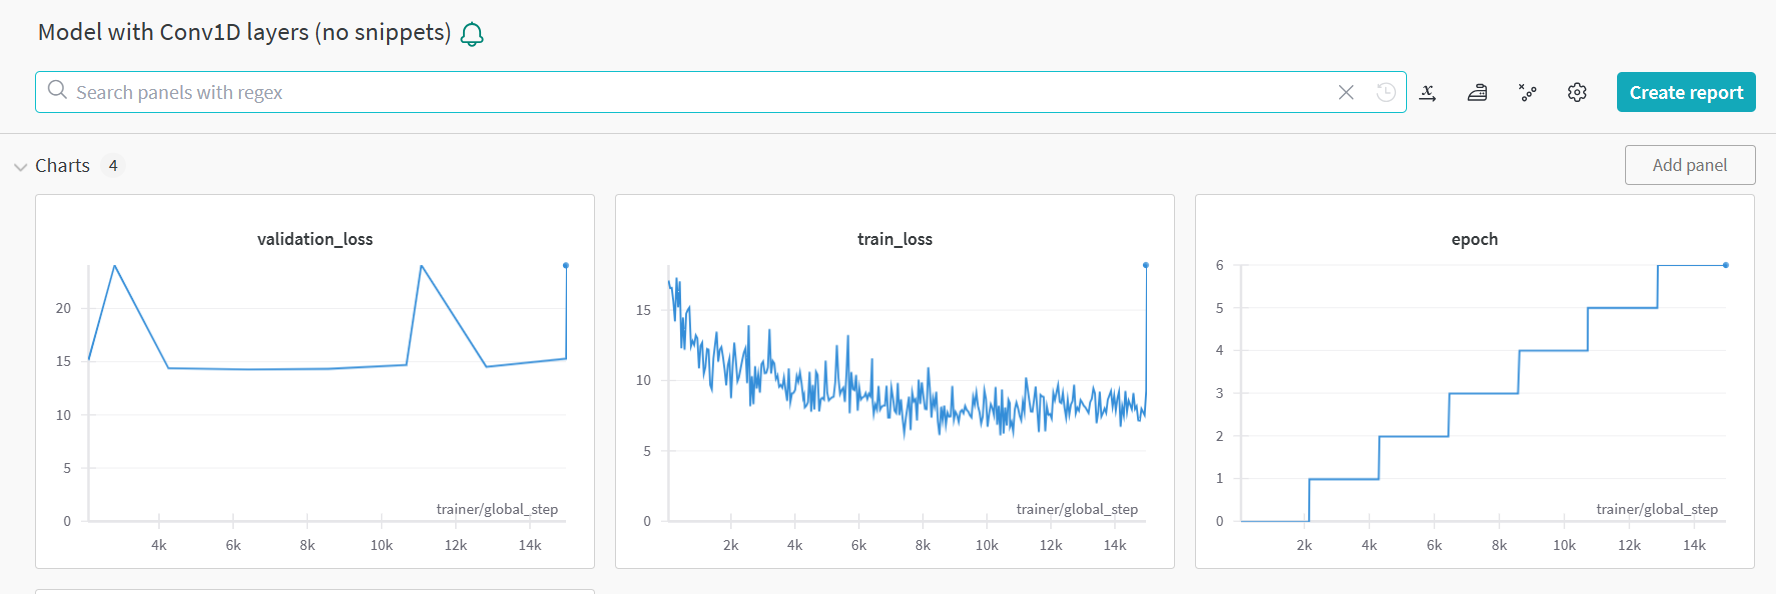

**Results of the experiments:** to try and improve the quality of the baseline model, I added some Conv1D layers, adaptive average pooling along with Relu activation function. Having experimented with different values of hyperparameters, the final val_loss is 13.30 which is significantly worse compared to the quality of the baseline model (see Charts above). The loss on the training portion is comparatively the same, however adding conv layers leads to overfitting and bad results on validation set.

__[0.5]__ Скачайте с сайта [Rusvectores](https://rusvectores.org/ru/models/) любые новостные word2vec эмбединги. Возьмите из модели эмбеддинги для всех слов, которые встречаются вв вашем словаре и добавьте их в модель первым слоем. Заморозьте этот слой и не обновляйте в нём веса. Если у вас в словаре есть слово, но его нет среди предобученных эмбеддингов, замените его на токен `#UNKN`.

__Ваш лог экспериментов:__

-
-
-

In [57]:
from gensim.models import KeyedVectors
from torch.nn.functional import embedding

In [58]:
word_embeddings = KeyedVectors.load_word2vec_format('/content/model.bin', binary=True, unicode_errors='ignore')

In [65]:
def get_pretrained_embeddings(word_embeddings, vocabulary, embedding_dim):
    embeddings = torch.randn(len(vocabulary), embedding_dim)

    for word, idx in vocabulary.items():
        if word in word_embeddings:
            embeddings[idx] = torch.tensor(word_embeddings[word])
        else:
            if "UNKN" in word_embeddings:
                embeddings[idx] = torch.tensor(word_embeddings["UNKN"])
            else:
                # doesnt work without this
                embeddings[idx] = torch.zeros(embedding_dim)

    return embeddings

In [66]:
pretrained_embeddings = get_pretrained_embeddings(word_embeddings, vocabulary, EMBEDDING_DIM)

In [68]:
# update the model's architecture to make sure it processes everything correctly
class SimpleClassifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, output_dim, word_embeddings):
        super().__init__()

        # adding a frozen embedding layer with pre-trained word embeddings
        self.embedding = nn.Embedding.from_pretrained(word_embeddings, freeze=True)

        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, title):
        embedded = self.embedding(title)
        embedded = embedded.mean(dim=1)
        return self.fc(embedded)

In [69]:
baseline_embeddings_model = SimpleClassifier(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM, pretrained_embeddings)

In [70]:
wandb_logger = WandbLogger(name='Simple Model With New Embeddings', log_model='all')
criterion = torch.nn.CrossEntropyLoss()

train_module =TrainLightningModule(baseline_embeddings_model, LR, criterion)

trainer = pl.Trainer(logger=wandb_logger, accelerator="gpu", max_epochs=EPOCHS)
trainer.fit(train_module, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | SimpleClassifier | 34.1 M
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
476 K     Trainable params
33.6 M    Non-trainable params
34.1 M    Total params
136.342   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


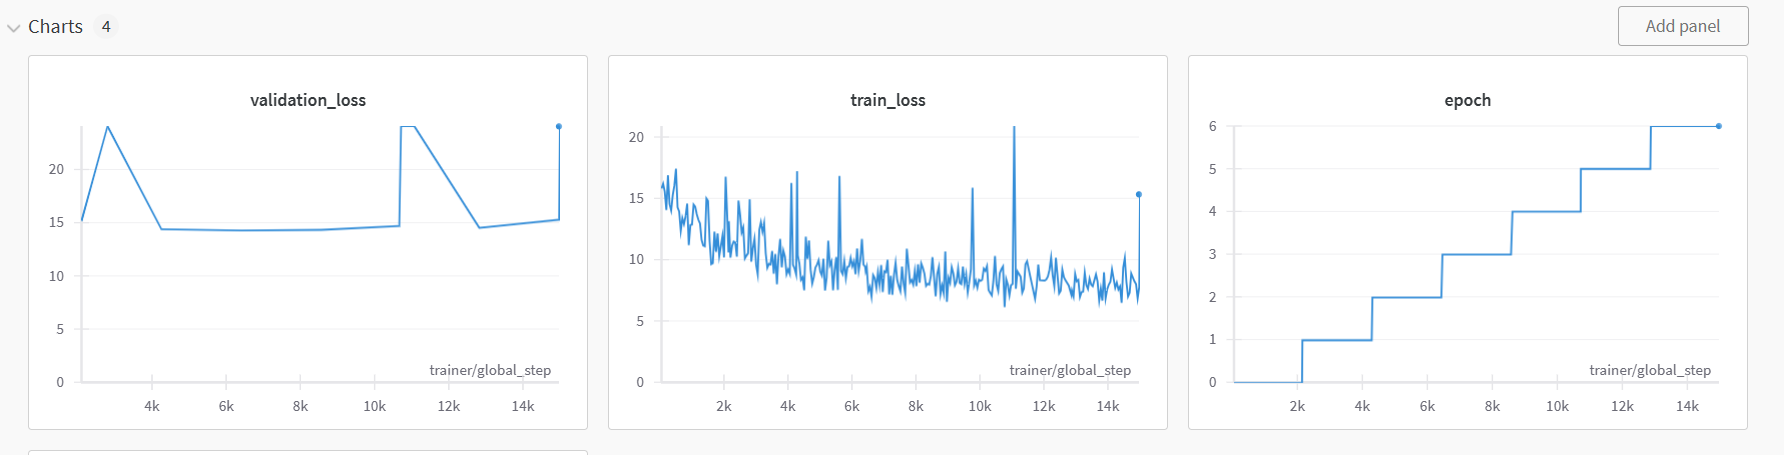

**Results of the experiments:** the model performed worse than the previous ones. I would assume it's because of the embeddings that I chose from the website. Maybe the news that were presented there had nothing to do with the news we are working here on, and so it makes sense that the quality got worse.

__[1 балл]__ Зафайнтьюньте трансформер для решения задачи с помощью библиотеки `hugging face`. Выбор предобученной модели кратко обоснуйте.

__Ваш лог экспериментов:__

-
-
-

In [77]:
!pip install torch transformers

In [78]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

In [84]:
model_name = 'bert-base-uncased'
pretrained_model = BertForSequenceClassification.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
learning_rate = 5e-5
lightning_module = TrainLightningModule(model=pretrained_model, learning_rate=learning_rate)

trainer = pl.Trainer(max_epochs=7)
trainer.fit(lightning_module, train_dataloader, val_dataloader)

Сравните все обученные модели между собой на тестовой выборке.

In [73]:
# assesing the quality of the first model
y_prob_conv, target = get_predict(model_conv, test_dataset)
y_pred_conv = 1*(y_prob_conv > threshold_value)

print('Exact Match for Model with Conv.layers:', exact_match(target, y_pred_conv))
print('Precision for Model with Conv.layers:', precision(target, y_pred_conv))
print('Recall for Model with Conv.layers:', recall(target, y_pred_conv))

Exact Match for Model with Conv.layers: 0.9985770583152771
Precision for Model with Conv.layers: 0.5756280422210693
Recall for Model with Conv.layers: 0.5055013298988342


In [76]:
# assesing the quality of the second model
y_prob_embed, target = get_predict(baseline_embeddings_model, test_dataset)
y_pred_embed = 1*(y_prob_embed > threshold_value)

print('Exact Match for Model with embed.layers:', exact_match(target, y_pred_embed))
print('Precision for Model with embed.layers:', precision(target, y_pred_embed))
print('Recall for Model with embed.layers:', recall(target, y_pred_embed))

Exact Match for Model with embed.layers: 0.9583156568527473
Precision for Model with embed.layers: 0.47895242245424574
Recall for Model with embed.layers: 0.50145015789634


## Часть 2: предсказание категорий (0.3 балла)

Возьмите датасет `df_vk` и для всех новостей из него предскажите категории с помощью лучшей, получившейся у вас модели.

In [ ]:
df_vk['target_tags'] = [[0]]*df_vk.shape[0]

# your code here
# (っ˘ڡ˘ς)

На всякий случай сохраните табличку с получившимися у вас предсказаниями. Мало ли, вы не доделаете последнее задание, а потом захотите вернуться к нему. Не прогонять же обучение нейросети и инференс по второму кругу...

In [ ]:
# Ваш код с сохранением данных

# your code here
# ¯\_(ツ)_/¯

## Часть 3: сентимент-классификатор (0.5 балла)

В этой части тетрадки нам предстоит прогнать все комментарии из ВК через сентимент-классификатор. Мы будем делать это с помощью библиотеки HuggingFace. В ней есть удобная [функциональность pipline,](https://huggingface.co/docs/transformers/pipeline_tutorial) чтобы прогонять на своих данных уже обученные модели. 🤗🤗🤗

In [ ]:
df_comments.head()

,id,post_id,datetime,text,likes
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0


Для классификации комментариев на позитивные, негативные и нейтральные будем использовать [модель, о которой можно почитать по ссылке](https://huggingface.co/seara/rubert-tiny2-russian-sentiment)

Ответьте на следующие вопросы:

1. Как зовут автора модели?
2. Как выглядит архитектура модели? Насколько модель большая?
3. На каких данных обучена модель? Адекватно ли использовать её для классификации комментариев ВК?

Установим библиотеку. 🤗🤗🤗

In [ ]:
!pip3 install transformers

Разберитесь как можно прогнать модель на корпусе комментариев и сделайте это. Да, с помощью pipeline можно запустить довольно сложные модели, обученные другими людьми в пару строчек. При объявлении модели не забудьте положить её на нужный `device` 🤗🤗🤗

In [ ]:
# your code here
# ʕ•ᴥ•ʔ

[{'label': 'positive', 'score': 0.9398769736289978}]

Цикл для сентимент-анализа комментариев может работать довольно долго. Я крайне рекомендую вам переодически сохранять к себе на компьютер промежуточные результаты. Итоговый результат я рекомендую записать отдельным столбиком в таблицу с комментариями, а затем сохранить полученные результаты. 🤗🤗🤗

In [ ]:
df_vk['sentiment_verdict'] = ...
df_vk['sentiment_score'] = ...

# <ваш код для сохранения данных>

# your code here
# ¯\_(ツ)_/¯

# P.S. Код для скоринга комментариев работает довольно долго. Первый, кто проскорит всю базу, может поделиться ей в общем чате с однокурсниками
# Если вы используете эту базу, просто продемонстрируйте при решении этого пункта, что ваш код работает

## Часть 4: аналитика (1 балл + 0.2 бонусных)

Мы с вами огромные молодцы. Мы обучили модель для категоризации новостей, построили с её помощью прогнозы. Мы проскорили комментарии на их сентимент-окрас. Теперь давайте проанализируем новости. Описывайте полученные результаты таким образом, чтобы не получить уголовку на 5 лет за дискредитацию чего-нибудь или оскорбление чувств кого-нибудь 💜

__[0.2 балла]__ Какая доля комментариев позитивная? Какая доля комментариев негативная? Выведите 10 самых позитивных комментариев.

Выведите 10 самых негативных комментариев, поугарайте с них. Удалите их вывод из тетрадки. Никто не должен их видеть, это должно остаться только между нами. Поззитивные не удаляйте. Они пусть останутся.

In [ ]:
# your code here
# ʕ•ᴥ•ʔ

__[0.2 балла]__ Для каждой новости из датасета посчитайте количество негативных и позитивных комментариев под ней. Сохраните эти количества в виде новых колонок.

In [ ]:
# your code here
# [✖‿✖]

__[0.2 балл]__ Правда ли, что новости с большим количеством лайков получают больше негативных комментариев? А позитивных? Правда ли, что чем больше лайков, тем под новостью больше комментариев?

Постройте визуализацию, которая могла бы это проиллюстрировать.

In [ ]:
# your code here
# ┌(ಠ_ಠ)┘

__[0.2]__  Давайте построим по сентимент-окрасу комментариев топ позитивных новостей.

- Если под новостью оставлено 100 комментариев, из которых 80 позитивные, мы можем быть уверены в том, что новость была хорошо воспринята людьми.
- Если под новостью всего один комментарий и он оказался позитивным, то у нас 100% позитивных комментариев, но это вовсе не означает, что новость была воспринята хорошо.

Получается, что сортировать по доле позитивных комментариев нельзя. Давайте поступим умнее. Доля позитивных комментариев под постом -- это случайная величина. Её довольно часто моделируют с помощью бета-распределения. Если это случайная величина, мы можем построить для неё предиктивный интервал. Пусть $u$ - число позитивных комментариев, а $d$ - нейтральных и негативных.  Пусть

$$
a = 1 + u \qquad b = 1 + d.
$$

Тогда нижняя граница $95\%$ предиктивного интервала для доли будет вычисляться по такой формуле:

$$
\frac{a}{a + b} - 1.65 \cdot \sqrt{\frac{a \cdot b}{(a + b)^2 \cdot (a + b + 1)}}
$$

Если под новостью был всего один комментарий, у такой случайной величины будет высокая дисперсия. Это означаen, что штука, которую мы вычитаем из доли, окажется высокой. Левая граница интервала окажется маленькой и мы не поднимем комментарий в нашем топе наверх. Фактически мы делаем сортировку по квантилю уровня $0.05$ вместо среднего.

От вас требуется вбить эту формулу, сделать сортировку и вывести на экран топ позитивных новостей. Подробнее про то, откуда берётся эта формула можно почитать [в этой книге.](https://disk.yandex.ru/i/Ctd08bTwC9eI3g) Ищите 4 главу, страницу 140.

In [ ]:
# your code here
# ฅ^•ﻌ•^ฅ

Построили? Срочно пришлите свою любимую позитивную  новость в общий чат!!!

Топ негативных новостей строить не будем. Вокруг итак слишком много негатива 😻😻😻

__[0.2]__ Какие категории новостей оказались самыми позитивными? Придумайте способ найти такие категории и опишите его тут.

__Ответ:__

In [ ]:
# your code here
# ٩(⁎❛ᴗ❛⁎)۶

__[0.2 бонусных]__ Проанализируйте, как температура комментария (вероятность того, что он негативный) зависит от длины трэда (число комментариев под новостью)? Значима ли эта взаимосвязь? Если вам для проверки этого хочется построить линейную регрессию, не сдерживайтесь.

In [ ]:
# your code here
# ヾ(๑╹◡╹)ﾉ